In [1]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
from clean_velocities import *
# tai from ... import *

# Database query

In [2]:
df = database_query("SELECT * FROM SensorData limit 50000")
df

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0
...,...,...,...,...,...,...
49995,b'-2393099149039893833',b'2020-07-07 13:36:08.795189+00:00',1277,-71,100,0
49996,b'-2393099149039893833',b'2020-07-07 13:36:18.794611+00:00',1278,-77,100,0
49997,b'-2393099149039893833',b'2020-07-07 13:36:27.794989+00:00',1277,-80,100,0
49998,b'-2393099149039893833',b'2020-07-07 13:36:38.793411+00:00',1273,-85,100,0


# Histogram of x and y coordinates

x mean:  1959.85514
y mean:  570.94314
x std:  878.0638038978605
y std:  1028.422147713156


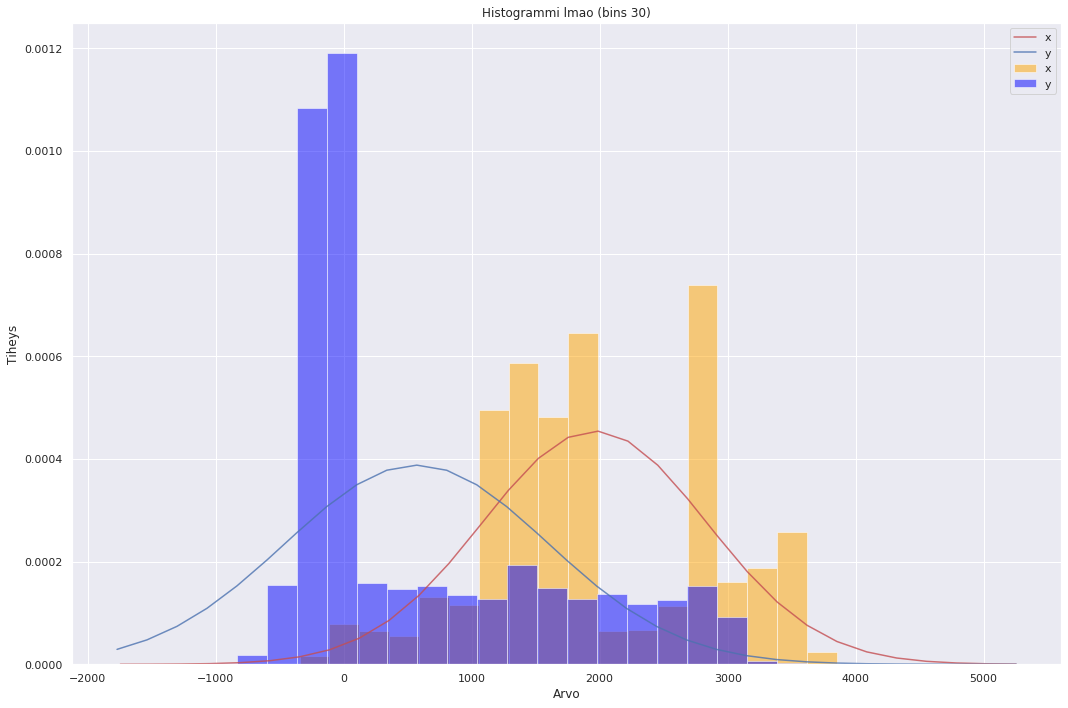

In [3]:
draw_histogram(df['x'], df['y'], 30)

# Find outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 3923
uniques in y 3955
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  50000
Ouliers removed:     148
Data after:  49852


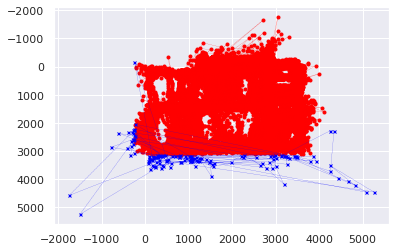

In [4]:
df1 = find_outliers(df)

Koko datasetissä (13 890 906)
- Data with outliers: 13 890 906
- Ouliers removed:    376 791
- Data after:         13 514 115

# Cleaning Node_id, timestamp, q, z columns

In [5]:
df1 = clean_dataframe(df1)
df1.head(5)

,node_id,timestamp,x,y
0,1,2020-06-24 15:20:08.533,2762,-257
1,1,2020-06-24 15:20:08.620,2870,-344
2,1,2020-06-24 15:20:09.623,2916,-344
3,1,2020-06-24 15:20:09.623,2894,-254
4,1,2020-06-24 15:20:10.116,2888,-188


# Katsotaan kuinka paljon kutakin nodea on käytetty

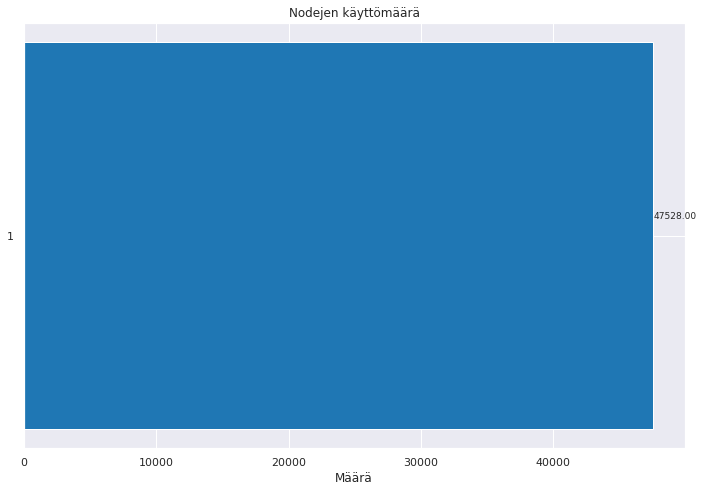

In [6]:
draw_node_amount(df1, 'node_id')

# Tehdään uuten tiedostoon Isolation Forestilla putsatut nodet

Dataframe lenght before: 94794
Dataframe lenght after: 94509
Total outliers detected: 285


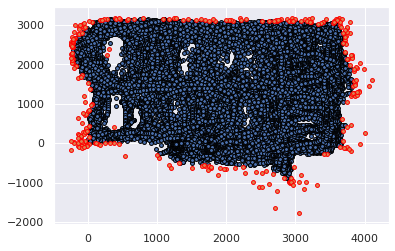

node numero 1 valmis


In [6]:
for i in range(len(df1.node_id.unique())):
    df1_node = isolation_forest(df1, 0, .003, i+1)
    print('node numero', i+1, 'valmis')
    
    if i == 0:
        df1_node.to_csv('./temp_data.csv', index=False)
    else:
        df1_node.to_csv('./temp_data.csv',mode='a', header=False, index=False)

In [7]:
df1 = pd.read_csv('./temp_data.csv')
import os
os.remove("./temp_data.csv") 
df1.head(5)

,node_id,timestamp,x,y
0,1,2020-06-24 15:20:08.533,2762,-257
1,1,2020-06-24 15:20:08.620,2870,-344
2,1,2020-06-24 15:20:09.623,2916,-344
3,1,2020-06-24 15:20:09.623,2894,-254
4,1,2020-06-24 15:20:10.116,2888,-188


# Poistetaan vialliset / puutteelliset nodet

In [7]:
df1 = df1[df1.node_id != 13]
df1 = df1[df1.node_id != 14]
df1 = df1[df1.node_id != 18]
df1 = df1[df1.node_id != 32]

# Adding xy_grid values to dataframe (50x50)

In [8]:
grid_size = 50
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
df1.head()

,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.533,2762,-257,33,15,783
1,1,2020-06-24 15:20:08.620,2870,-344,35,14,735
2,1,2020-06-24 15:20:09.623,2916,-344,35,14,735
3,1,2020-06-24 15:20:09.623,2894,-254,35,15,785
4,1,2020-06-24 15:20:10.116,2888,-188,35,15,785


# Poistetaan liiat nopeudet

In [9]:
x_column = df1.columns.get_loc('x')
print(abs(df1.iloc[0, x_column]))

2762


Uusi taulu:  40617
Poistettuja pisteitä:  51


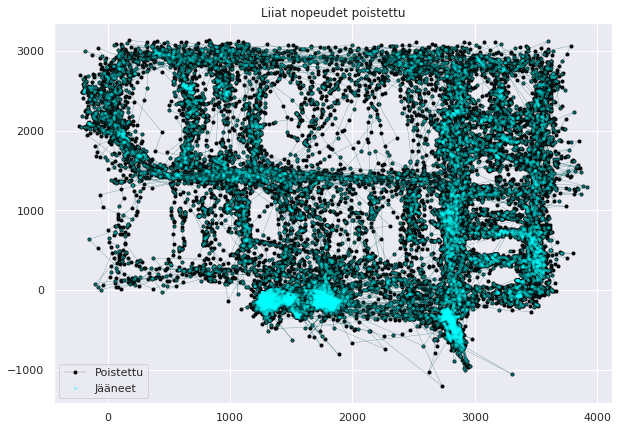

In [12]:
dftest = df1.copy()
table_alkuperäinen = len(df1['x'])

velocity.column_vel(df1, 'x', 'y')
velocity.draw_vel(dftest, df1, 'x', 'y')

# Write cleaned and diskretized dataframe to mariadb database

In [6]:
# Already writed, need to make update function
#write_df_to_mariadb(df1)

# Find and draw exits

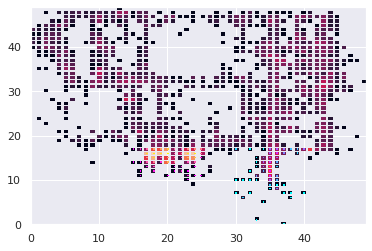

In [19]:
in_x, in_y = sisään(df1)
out_x, out_y = ulos(df1)

draw_exits(df1, in_x, in_y, out_x, out_y)

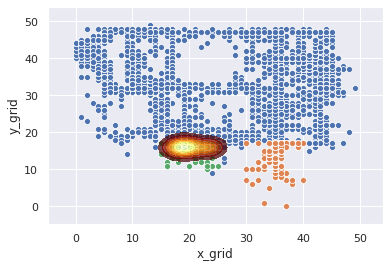

In [27]:
# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# # Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()


### Erotetaan kauppareissut toisistaan

In [28]:
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, 50)
df_reitit = reitit_dataframeksi(reitit)


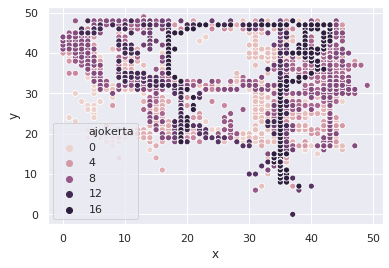

In [30]:
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

445


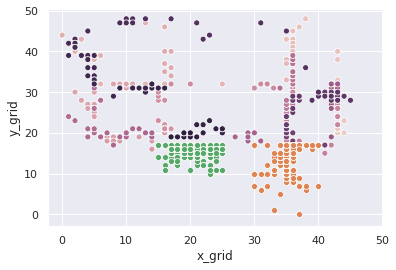

574


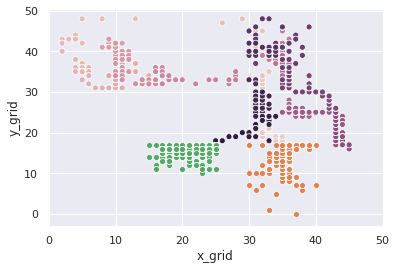

403


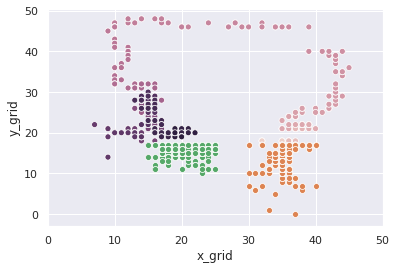

348


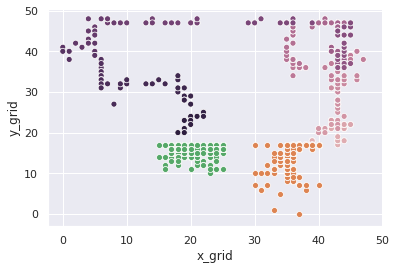

201


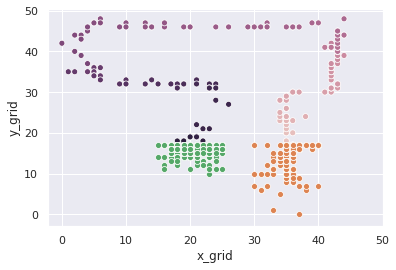

432


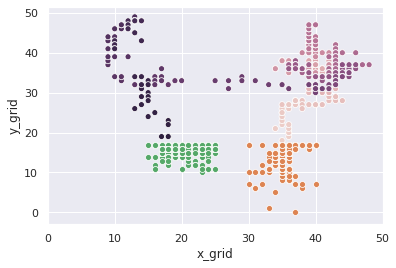

270


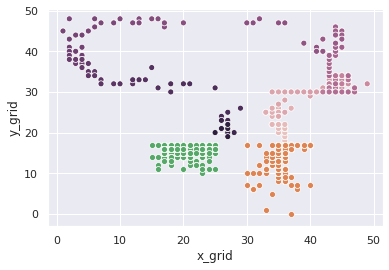

392


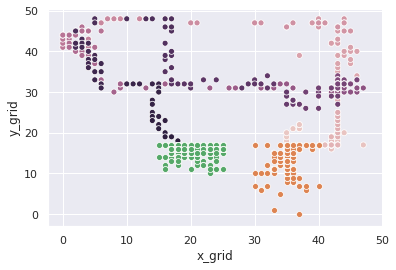

150


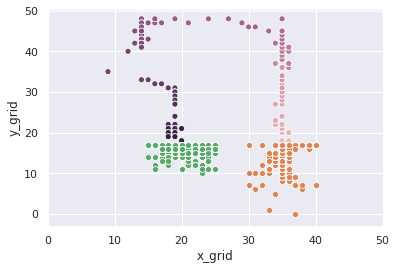

79


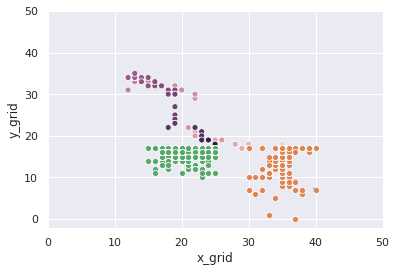

201


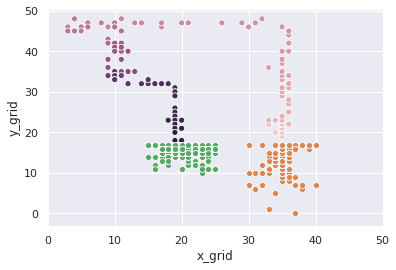

436


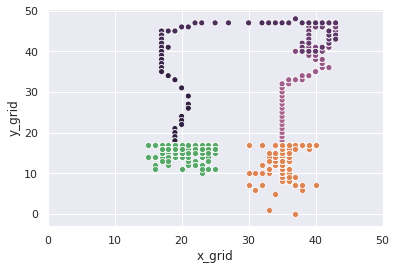

In [31]:
# Plottaa jokaisen kauppareissut erikseen.

plot_unique_routes(df_reitit, grid_size, in_x, in_y, out_x, out_y)   
# Ensimmäisissä on aika paljon häiriötä

In [51]:
lapimeno = get_lapimeno(reitit, 50)

Läpimenoajat [Timedelta('0 days 18:00:06.612000'), Timedelta('0 days 01:53:48.006000'), Timedelta('0 days 00:23:41.181000'), Timedelta('0 days 00:11:19'), Timedelta('0 days 00:40:12.999000'), Timedelta('0 days 00:09:23'), Timedelta('0 days 02:11:01.999000'), Timedelta('0 days 00:14:57.998000'), Timedelta('1 days 18:10:10.999000'), Timedelta('0 days 01:16:09.002000'), Timedelta('0 days 02:10:48.999000'), Timedelta('0 days 16:53:07.772000')]
